# Introduction

My student Rebecca and I are interested in training a model to detect [water tracks](https://frontierscientists.com/projects/changing-earth-science/watertracks/) in Arctic satellite data. 

Out workflow is as follows:
1. Use [watershed boundaries](https://developers.google.com/earth-engine/datasets/catalog/WWF_HydroSHEDS_v1_Basins_hybas_10)(`.shp`) from Google Earth Engine to query both PlanetScope and Sentinel 2 RGB imagery. Planet imagery is delivered in strips, so we (1) mosaic strips together and then (2) tile the mosaic (I think 1024x1024). We download S2 imagery from GEE which allows you to export as tiles (512x512). 
def labels_to_tiff_pl(label_data_path, xml_path):
def labels_to_tiff_pl(label_data_path, xml_path):
2. We convert these tiled GeoTIFFS to JPEGs via `gdal` which produces `.aux.xml` files that contain the georeferencing for the JPEGs. We note the name of this folder because it will be the `xml_path` variable in the following scripts. The files all have a format of 

`[ten digit HYBAS ID]_[date]_[tile identifier e.g. "1_1" from gdal or "0001024_0000512" from Earth Engine].jpg`

We will be parsing the first ten digits to re-mosaic the output labels by HYBAS ID, and then also separate out user IDS. 

3. We import to Doodler and create binary lables ("water track" is 0 and "not water track" is 1). The two users *often* remember to change the "enter user ID" but sometimes they (me) forget and I have to ret con with a shell script. 
4. We run the `gen_images_and_labels.py` utility. The `*labels*` folder that results from this will be the `label_data_path` variable. 

In [ ]:
from osgeo import gdal
import glob, os, shutil
import pathlib
from pathlib import Path 

In [ ]:
def labels_to_tiff_pl(label_data_path, xml_path):
    # label_data_path is directory of LABEL files
    # xml_path is the directory of XMLs generated in the tif-to-jpeg step 
#     """
#   matches original tif-to-jpeg Planet files with labels generated in Doodle
#   you gotta run the gen_images_and_labels.py in doodler after you get results from doodler
#   """

    print("converting labels to tiffs!")

    label_data_path = Path(label_data_path)

    new_tif_dir = Path(f'{label_data_path.parents[0]}/converted_tiffs')
    new_tif_dir.mkdir(exist_ok=True)
    print("Created directory for converted tiffs at ", new_tif_dir.as_posix())

    for file in label_data_path.glob("*_label.jpg"):
        shutil.copy(file.as_posix(), (new_tif_dir).as_posix())
   
    print("Copied labels to ", new_tif_dir.as_posix())

    xml_path = Path(xml_path)

    for xml in xml_path.glob('*.xml'):
        print("Trying to match ", xml)
        file = xml.stem.split('.')[0]

        for path_match in label_data_path.glob(f'{file}*_label.jpg'):
            file_match = Path(path_match).stem
            print("Match found with ", path_match)
            shutil.copy(xml, new_tif_dir / f'{file_match}.jpg.aux.xml')
            shutil.copy(xml, new_tif_dir / f'{file_match}.tif.aux.xml') # this can't be right...

            options_list = [
            '-of GTiff',
            ]  

            options_string = " ".join(options_list)  

            tifname = path_match.stem.split('.')[0]

            gdal.Translate(
                (new_tif_dir / f'{tifname}.tif').as_posix(),
                path_match.as_posix(),
                options=options_string
            )
            
    
    print("Converted label jpegs to tiffs!")

In [ ]:
def labels_by_hybas(tif_dir):
#     """
# groups labels converted to tifs by HYBAS ID in your working directory
# tif_dir is the directory of tif files created from the labels
#      """
    from osgeo import gdal, osr
    import glob, os, shutil
    import pathlib
    from pathlib import Path 
    import numpy as np

    tif_dir = Path(tif_dir)
   
    ids = np.unique(
        np.array([
            file.stem[:10]
            for file in tif_dir.glob('*.tif')
        ])
    )

    print("Number of files you should see: ", str(len(ids)))

    for id in ids:
        files = [path.as_posix() for path in tif_dir.glob(f'{id}*.tif')]

        d = gdal.Open(str(files[0]))
        prj = d.GetProjection()
        srs = osr.SpatialReference(wkt=prj)

        authority = srs.GetAttrValue("AUTHORITY", 1)

        filename = f"{id}_labels.tif"

        # Yo what is no data in labels 

        outvrt = 'all.vrt'

        outds = gdal.BuildVRT(outvrt, files)

        final_outds = gdal.Warp(outvrt, outds, dstSRS=(f'EPSG:{authority}'))
        final_outds = gdal.Translate(
            filename, final_outds, format = "GTiff",
            # creationOptions['TILED:YES']
            )
        final_outds = None
        outvrt = None

        # Maybe an "if" statement here fam lol
        # print("Created ", filename)

Sometimes labels went beyond the extent of the image, probably because in the conversion of GeoTIFF to JPEG some of the "no data" got warped/interpolated somehow. 

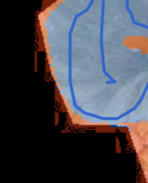

So I have an extra step to "cookie-cutter" out the real data by the bounds of the watershed shapefile. 

In [ ]:
def cut_labels(shapefile_dir):
    #     """
# crop label geotifs to matching shapefile extent
#      """
    from osgeo import gdal, osr
    import glob, os, shutil
    import pathlib
    from pathlib import Path 
    import numpy as np

    shapefile_dir = Path(shapefile_dir)

    for tif_path in glob.glob('*.tif'):
        tif_path = Path(tif_path)
        id = tif_path.stem[:10]
        print(id)
        for shapefile in shapefile_dir.glob((f'{id}.shp')):
            print(shapefile)
            # You might want to check if the crs of the shapefile matches that of the tif

            # print("shapefile: ",shapefile)
            # print("dest: ", (f'{id}_cropped.tif'))
            # print ("src: ", tif_path)

            ds = gdal.Warp(destNameOrDestDS = (f'{id}_cropped.tif'), 
                    srcDSOrSrcDSTab  = tif_path.as_posix(), 
                    cutlineDSName    = shapefile.as_posix(),
                    format = 'GTiff',
                    cropToCutline    = True,
                    copyMetadata     = True,
                    dstNodata        = 9999)

            ds = None

In [ ]:
def labels_by_hybas_and_user(tif_dir, user_id):
#     """
# groups labels converted to tifs by HYBAS ID in your working directory
# and also by user in the case that multiple users labeled the same watershed
# tif_dir is the directory of tif files created from the labels
#      """
    from osgeo import gdal, osr
    import glob, os, shutil
    import pathlib
    from pathlib import Path 
    import numpy as np

    original_wd = os.getcwd()
    # root = tk.Tk()
    # root.filename =  filedialog.askdirectory(initialdir = os.getcwd(),title = "Select directory of LABEL TIFF files")
    tif_dir = Path(tif_dir)
   
#    # The following approach is TRASH
#     os.chdir(tif_dir.as_posix())
#     print("Changed working directory to", os.getcwd())
#     # root.withdraw()

    ids = np.unique(
        np.array([
            file.stem[:10]
            for file in tif_dir.glob(f'*{user_id}*.tif')
        ])
    )

    print("Number of files you should see: ", str(len(ids)))

    for id in ids:
        files = [path.as_posix() for path in tif_dir.glob(f'{id}*{user_id}*.tif')]

        d = gdal.Open(str(files[0]))
        # proj = osr.SpatialReference(wkt=d.GetProjection())
        prj = d.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        # print("srs is ",srs)

        # print("Hey, is the right EPSG ", srs.GetAttrValue("AUTHORITY", 1))
        authority = srs.GetAttrValue("AUTHORITY", 1)

        # wkt_string = f"gdalsrsinfo -o wkt {files[0]} > target.wkt"
        # os.system(wkt_string)

        filename = f"{id}_{user_id}_labels.tif"

        # Yo what is no data in labels 

        outvrt = 'all.vrt'

        outds = gdal.BuildVRT(outvrt, files)
        # outds = gdal.Translate(filename, outds)
        final_outds = gdal.Warp(outvrt, outds, dstSRS=(f'EPSG:{authority}'))
        final_outds = gdal.Translate(
            filename, final_outds, format = "GTiff",
            # creationOptions['TILED:YES']
            )
        final_outds = None
        outvrt = None

        # Maybe an "if" statement here fam lol
        # print("Created ", filename)
    # os.chdir(original_wd)

# Test 1: Planet mosaics

In [ ]:
label_data_path = ("./PL/images_and_labels/Batch1_images_and_labels/labels") # NOT the balanced_classes result
xml_path = ("./PL/shapefiles")

In [ ]:
labels_to_tiff_pl(label_data_path, xml_path)

In [ ]:
labels_by_hybas("./PL/images_and_labels/Batch1_images_and_labels/converted_tiffs")

In [ ]:
cut_labels("./PL/shapefiles")

The result is often this:

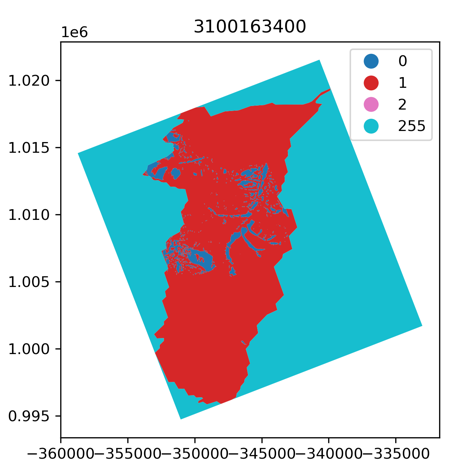

Two things: apparently I am not actually masking out nodata when I `cut_labels` because that's all the 255 data (that then gets reprojected to polar coordinates), which seems like an easy fix. Weirder is the odd appearance of a "2" class. The number of "2" pixels in each mosaic ends up being constant (if I remember in the ~70,000 range?) and visually imperceptible so I coudln't see exactly where they were. But because for my purposes I was interested in counting % of the mosaic that had a value of 0 versus the total of 0 and 1 (% water tracks in a watershed), I ignored these things but probably shouldn't :shrug:. 


A bigger issue was when somehow my "0" class arbitrarily became "no data":

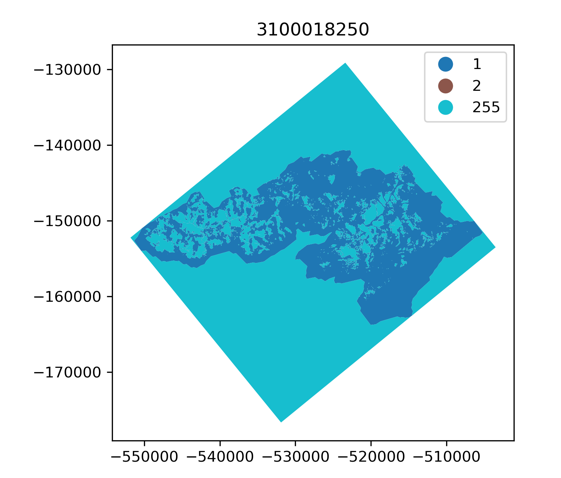

Once again, I remedied this by cookie-cutting *again* and then just doing 1-(counts of class 1)/total. But this was only discovered when I visually inspected each output. 

# Test 2: Sentinel 2 tiled jpgs from Google Earth Engine

In [ ]:
label_data_path = ("./S2/images_and_labels") # NOT the balanced_classes result
xml_path = ("./S2/geotiffs/jpgs_from_ee")
labels_to_tiff_pl(label_data_path, xml_path)

In [ ]:
label_data_path = ("./S2/DoodlerResults/other_results/labels") # NOT the balanced_classes result
xml_path = ("./S2/geotiffs/jpgs_from_ee")
labels_to_tiff_pl(label_data_path, xml_path)

In [ ]:
labels_by_hybas_and_user("./S2/DoodlerResults/other_results/converted_tiffs", "RR")

In [ ]:
labels_by_hybas_and_user("./S2/converted_tiffs", "JD")

In [ ]:
cut_labels("./PL/shapefiles")

The result?:

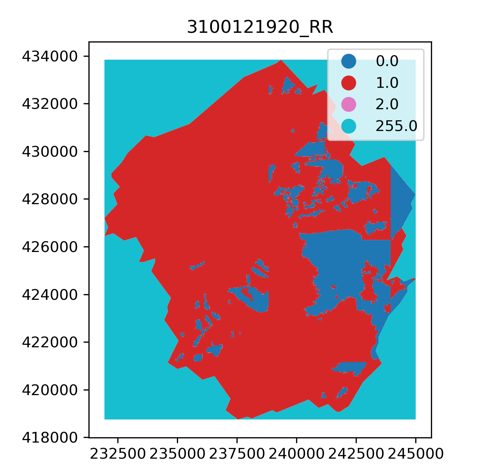

Not bad. 

More of an us problem (and really more of a me problem) is if Doodler crashes it'll save files but instead of nodata it'll be zero apparently because we had a few of these:

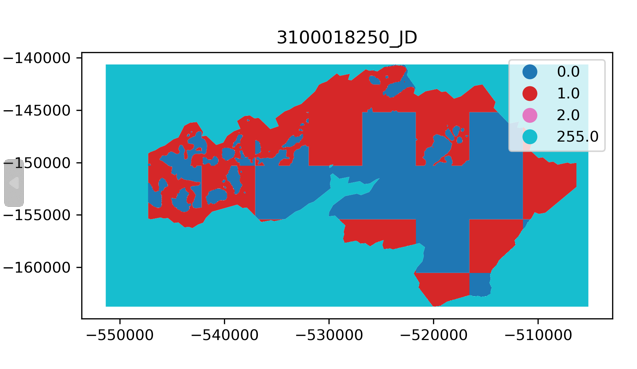

Outside of having Doodler not crash this can be rememdied by keeping a closer eye on the Doodler results directory to make sure your files look like what they should. 